In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import Tuple
import imageio.v3 as iio

In [6]:


def correction_illumination(I1: np.ndarray, I2: np.ndarray, window_shifting: np.ndarray, size_average: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Adjust the illumination of images I1 and I2 based on a window shifting and averaging process.

    Args:
        I1 (np.ndarray): First input image.
        I2 (np.ndarray): Second input image.
        window_shifting (np.ndarray): Window shifting parameters.
        size_average (int): Size for averaging.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Adjusted images I1 and I2.
    """
    I1 = I1.astype(np.float64)
    I2 = I2.astype(np.float64)

    x3, y3, x4, y4 = window_shifting[:4]
    I1_mean = np.mean(I1[y3:y4, x3:x4])
    I2_mean = np.mean(I2[y3:y4, x3:x4])
    R12 = I1_mean / I2_mean
    I2 = R12 * I2

    if size_average > 0:
        N = size_average
        h = np.ones((N, N)) / (N * N)
        I12F = cv2.filter2D(I1, -1, h) - cv2.filter2D(I2, -1, h)
        I2 = I2 + I12F
    else:
        I2 = I2

    return I1, I2

def pre_processing_a(I1: np.ndarray, I2: np.ndarray, scale_im: float, size_filter: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Pre-process images to reduce random noise and downsample if displacements are large.

    Args:
        I1 (np.ndarray): First input image.
        I2 (np.ndarray): Second input image.
        scale_im (float): Scale factor for downsizing images.
        size_filter (int): Size of the Gaussian filter for removing random noise.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Pre-processed images I1 and I2.
    """
    I1 = cv2.GaussianBlur(I1, (size_filter, size_filter), 0)
    I2 = cv2.GaussianBlur(I2, (size_filter, size_filter), 0)

    if scale_im < 1:
        I1 = cv2.resize(I1, None, fx=scale_im, fy=scale_im, interpolation=cv2.INTER_AREA)
        I2 = cv2.resize(I2, None, fx=scale_im, fy=scale_im, interpolation=cv2.INTER_AREA)

    return I1, I2

def optical_flow_physics_fun(I1: np.ndarray, I2: np.ndarray, lambda_1: float, lambda_2: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, float]:
    """
    Compute the optical flow between two images using the Horn-Schunck method.

    Args:
        I1 (np.ndarray): First input image.
        I2 (np.ndarray): Second input image.
        lambda_1 (float): Smoothness parameter for the initial field.
        lambda_2 (float): Smoothness parameter for the refined estimation.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, float]: Velocity fields and error.
    """
    flow = cv2.calcOpticalFlowFarneback(I1, I2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    ux, uy = flow[..., 0], flow[..., 1]
    vor = np.sqrt(ux**2 + uy**2)
    ux_horn = cv2.Sobel(ux, cv2.CV_64F, 1, 0, ksize=5)
    uy_horn = cv2.Sobel(uy, cv2.CV_64F, 0, 1, ksize=5)
    error = np.mean(np.abs(ux_horn) + np.abs(uy_horn))

    return ux, uy, vor, ux_horn, uy_horn, error

def shift_image_fun_refine_1(ux_corr: np.ndarray, uy_corr: np.ndarray, Im1: np.ndarray, Im2: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Shift the image Im1 based on the velocity field (ux_corr, uy_corr) and compute the velocity difference for iterative correction.

    Args:
        ux_corr (np.ndarray): Velocity field in the x-direction.
        uy_corr (np.ndarray): Velocity field in the y-direction.
        Im1 (np.ndarray): First input image.
        Im2 (np.ndarray): Second input image.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Shifted image Im1, and velocity differences uxI, uyI.
    """
    rows, cols = Im1.shape
    flow = np.stack((ux_corr, uy_corr), axis=-1)
    Im1_shift = cv2.remap(Im1, flow, None, cv2.INTER_LINEAR)

    flow_inv = np.stack((-ux_corr, -uy_corr), axis=-1)
    Im2_shift = cv2.remap(Im2, flow_inv, None, cv2.INTER_LINEAR)

    uxI, uyI = cv2.calcOpticalFlowFarneback(Im1_shift, Im2_shift, None, 0.5, 3, 15, 3, 5, 1.2, 0)[..., 0], cv2.calcOpticalFlowFarneback(Im1_shift, Im2_shift, None, 0.5, 3, 15, 3, 5, 1.2, 0)[..., 1]

    return Im1_shift, uxI, uyI


In [9]:

# def main():
"""
Main program for extraction of velocity field from a pair of flow visualization images.
"""
# Read a pair of images
Im1 = iio.imread('../images/White_Oval_1.tif')
Im2 = iio.imread('../images/White_Oval_2.tif')



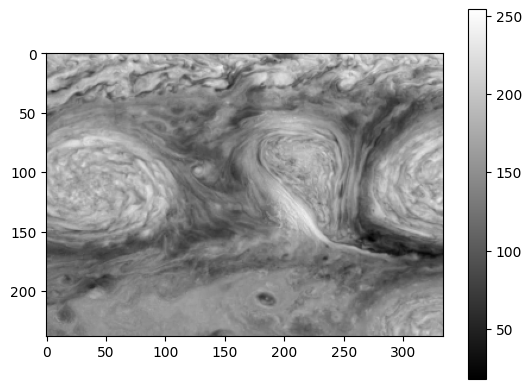

/tmp/ipykernel_1410517/2642675146.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  xy = plt.ginput(2)


TypeError: list indices must be integers or slices, not tuple

<Figure size 640x480 with 0 Axes>

In [11]:


# Set the parameters for optical flow computation
lambda_1 = 20  # Horn-Schunck estimator for initial field
lambda_2 = 2000  # Liu-Shen estimator for refined estimation
no_iteration = 1  # Number of iterations in the coarse-to-fine iterative process
scale_im = 0.5  # Scale factor for downsizing images
size_average = 0  # Size for averaging to bypass local illumination intensity adjustment
size_filter = 4  # Gaussian filter size for removing random noise
index_region = 1  # Select a region for processing (1) or process the whole image (0)

# Select a region of interest for diagnostics
if index_region == 1:
    plt.imshow(Im1, cmap='gray')
    plt.colorbar()
    plt.axis('image')
    plt.show()

    xy = plt.ginput(2)
    x1, x2 = int(np.floor(min(xy[:, 0]))), int(np.floor(max(xy[:, 0])))
    y1, y2 = int(np.floor(min(xy[:, 1]))), int(np.floor(max(xy[:, 1])))
    Im1 = Im1[y1:y2, x1:x2]
    Im2 = Im2[y1:y2, x1:x2]
elif index_region == 0:
    pass

Im1_original = Im1.copy()
Im2_original = Im2.copy()

# Correct the global and local intensity change in images
window_shifting = np.array([1, Im1.shape[0], 1, Im1.shape[1]])
Im1, Im2 = correction_illumination(Im1, Im2, window_shifting, size_average)

# Pre-process for reducing random noise and downsampling images if displacements are large
Im1, Im2 = pre_processing_a(Im1, Im2, scale_im, size_filter)

I_region1 = Im1.copy()
I_region2 = Im2.copy()

# Initial optical flow calculation for a coarse-grained velocity field
ux0, uy0, vor, ux_horn, uy_horn, error1 = optical_flow_physics_fun(I_region1, I_region2, lambda_1, lambda_2)

# Generate the shifted image from Im1 based on the initial coarse-grained velocity field (ux0, uy0)
Im1 = cv2.convertScaleAbs(Im1_original)
Im2 = cv2.convertScaleAbs(Im2_original)

ux_corr = ux0.copy()
uy_corr = uy0.copy()

# Estimate the displacement vector and make correction in iterations
k = 1
while k <= no_iteration:
    Im1_shift, uxI, uyI = shift_image_fun_refine_1(ux_corr, uy_corr, Im1, Im2)

    # Calculation of correction of the optical flow
    ux_corr, uy_corr, vor, ux_horn, uy_horn, error2 = optical_flow_physics_fun(Im1_shift, Im2, lambda_1, lambda_2)

    k += 1

# Refined velocity field
ux = ux_corr
uy = uy_corr

# Show the images and processed results
plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(Im1_original, cmap='gray')
plt.title('Original Image 1')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(Im2_original, cmap='gray')
plt.title('Original Image 2')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.quiver(ux, uy, scale=1, angles='xy', scale_units='xy')
plt.title('Velocity Field')
plt.axis('equal')

plt.subplot(2, 2, 4)
plt.imshow(vor, cmap='jet')
plt.title('Velocity Magnitude')
plt.colorbar()

plt.show()
